# ECG - V beat identification

In [207]:
import cv2
import os
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
import pandas as pd
import math
from collections import Counter

In [208]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, plot_confusion_matrix

### Image analysis

In [209]:
im = cv2.imread('train/'+ os.listdir('train')[0])
im.shape

(750, 7522, 3)

In [ ]:
#Find unique colors in the image

color_data = []
for i in range(750):
    color_data.append( np.unique(im[i], axis = 0) )

color_data

Image doesn't have fix colors, range of colors need to be identified using boundary thresholds

In [211]:
def detect_pixels(im, color):
    '''
    Identifies all pixels pertaining to a color, using thresholding
    Visualizing function
    '''
    
    # define the list of boundaries for blue, black and green
    boundaries = {'blue':([65, 0, 0], [255, 50, 50])
                  ,'black': ([0,0,0], [50,50,50])
                  ,'light blue': ([255,216,216], [255,216,216])
                  ,'green': ([0,128,0], [50,255,50])        
                 }
    
    lower, upper = boundaries[color]
    # create NumPy arrays from the boundaries
    lower = np.array(lower, dtype = "uint8")
    upper = np.array(upper, dtype = "uint8")
    # find the colors within the specified boundaries and apply
    # the mask
    mask = cv2.inRange(im, lower, upper)
    cv2.imwrite('temp.jpg',mask)
    output = cv2.bitwise_not(mask) #and(im, im, mask = mask)

    return output

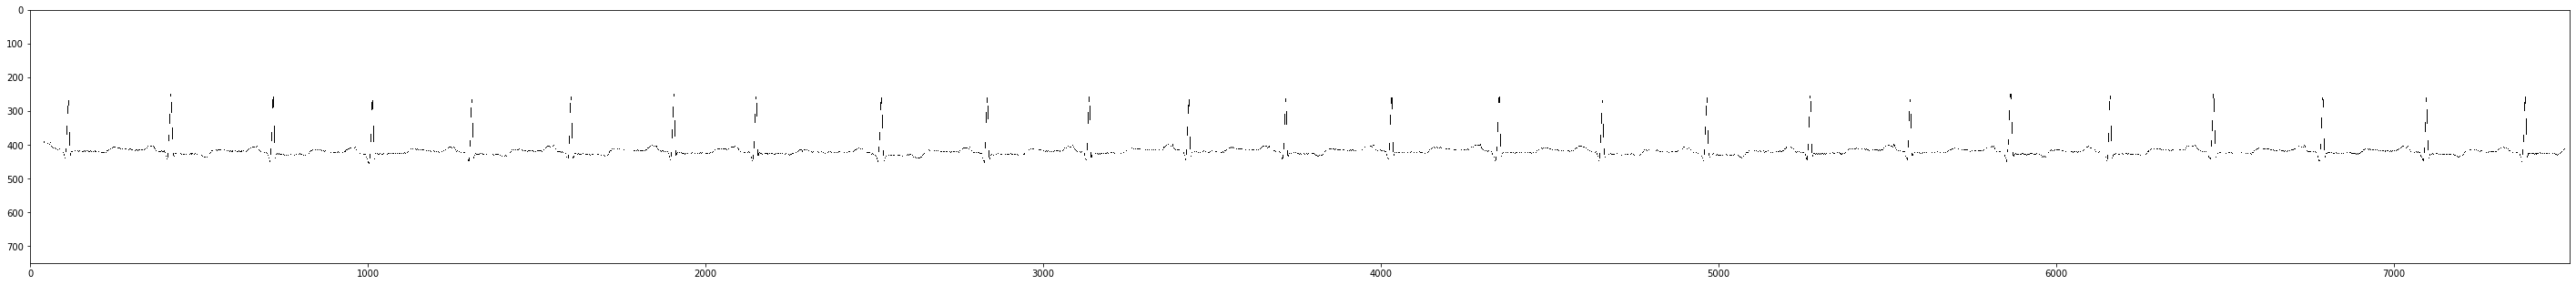

In [212]:
plt.figure(figsize=(50,100))
plt.imshow(cv2.cvtColor(detect_pixels(im, 'black'), cv2.COLOR_BGR2RGB))
plt.show()

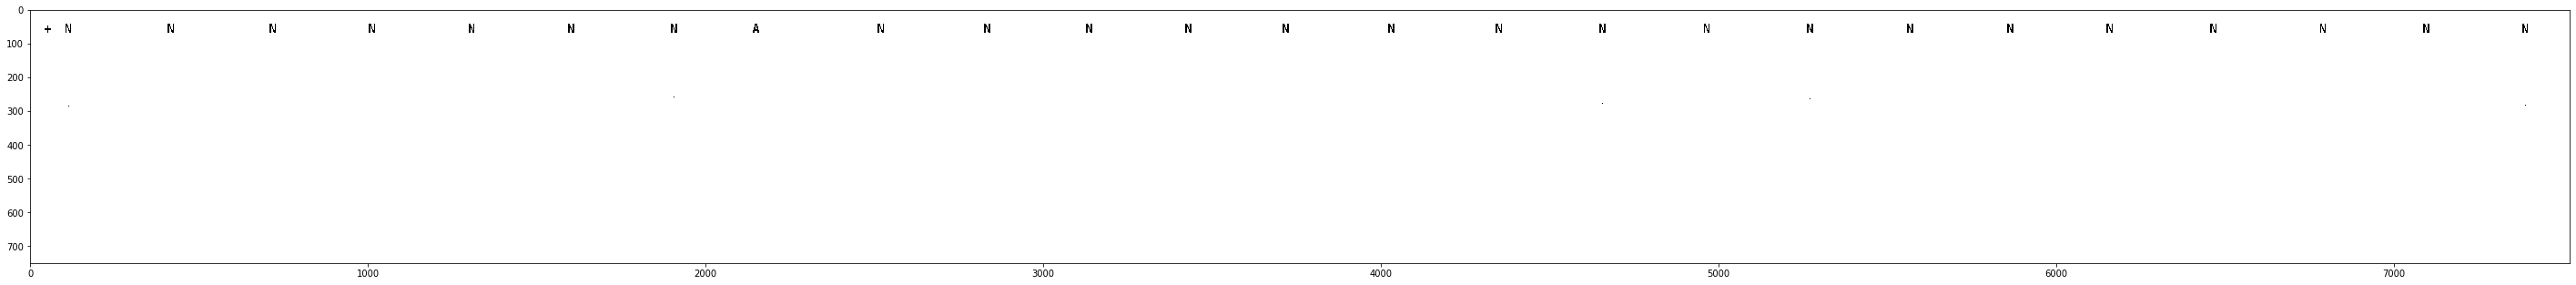

In [213]:
plt.figure(figsize=(50,100))
plt.imshow(cv2.cvtColor(detect_pixels(im, 'blue'), cv2.COLOR_BGR2RGB))
plt.show()

### Pre-processing

In [214]:
def find_x(img, input_color, visualize=False):
    '''
    Find the X coordinate corresponding to the input color
    '''

    #Reference: https://yangcha.github.io/ImageViewer/
    color_mapping = {'green': [0,128,0], 'blue':[255,0,0], 'black':[0,0,0]}
    color_code = color_mapping[input_color]
    
    #Find all x detections based on the color
    #reduce range to top 200 pixels for detection
    for j in range(0,200):
        center = img[j]
        x_pts = []
        for i, color in enumerate(center.tolist()):
            if color == color_code:
                x_pts.append(i)
#                 print (i, j)
        #if more than 10 points are found, use these detections
        if len(x_pts) > 10:
            break
            
    #Find avereage of all points within 30 pixels
    start, end = 0,0
    thresh = 30
    temp_arr, x_avg_det = [],[]
    while end < len(x_pts):
        if x_pts[end] - x_pts[start] < thresh:
            temp_arr.append(x_pts[end])
        else:
            start = end
            x_avg_det.append( round(np.mean(temp_arr)) )
            temp_arr = [x_pts[end]]
        
        end += 1
    #add in the last value
    x_avg_det.append( round(np.mean(temp_arr)) )
        
    if visualize == True:
        print (len(x_avg_det), x_avg_det)
        #visualize the point for detection
        plt.figure(figsize=(100,200))
        plt.imshow(cv2.cvtColor(detect_pixels(img, input_color), cv2.COLOR_BGR2RGB)[:100])
        plt.scatter(x_avg_det, [44]*len(x_avg_det), marker='.', s=20)
        plt.show()

    return x_avg_det

25 [113.0, 417.0, 719.0, 1013.0, 1308.0, 1602.0, 1907.0, 2150.0, 2520.0, 2835.0, 3137.0, 3431.0, 3719.0, 4032.0, 4351.0, 4657.0, 4966.0, 5272.0, 5568.0, 5865.0, 6160.0, 6467.0, 6791.0, 7097.0, 7390.0]


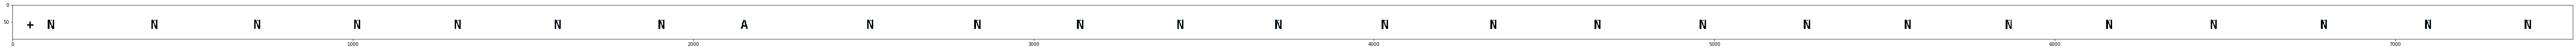

In [215]:
#visualize the N points. Expand image in new tab for zooming in  
im = cv2.imread('train/'+ os.listdir('train')[0])
a=find_x(im, 'blue', visualize=True)

28 [200.0, 482.0, 786.0, 1132.0, 1448.0, 1743.0, 2037.0, 2335.0, 2621.0, 2925.0, 3237.0, 3556.0, 3858.0, 4161.0, 4460.0, 4736.0, 5024.0, 5216.0, 5320.0, 5668.0, 5840.0, 6021.0, 6295.0, 6334.0, 6555.0, 6903.0, 7098.0, 7485.0]


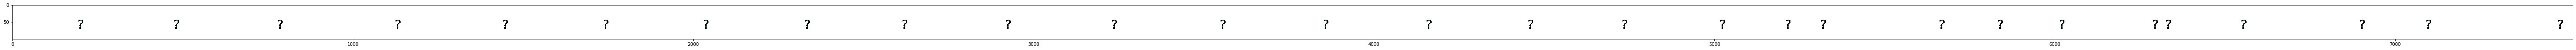

In [216]:
#visualize the ? points. Expand image in new tab for zooming in
temp_img = cv2.imread('test/b1_0.png')
a=find_x(temp_img, 'blue', visualize=True)

15 [165.0, 811.0, 1441.0, 1622.0, 2326.0, 2956.0, 3129.0, 3784.0, 4457.0, 4637.0, 5293.0, 5453.0, 6098.0, 6288.0, 6959.0]


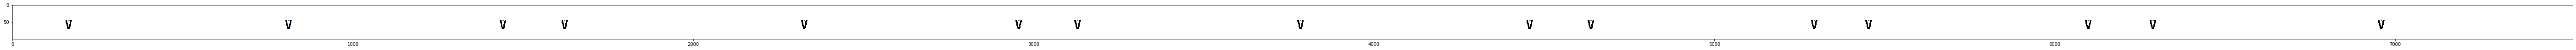

In [217]:
#visualize the V points. Expand image in new tab for zooming in
temp_img = cv2.imread('train/a3_6.png')
a=find_x(temp_img, 'green', visualize=True)

19 [283.0, 639.0, 1008.0, 1381.0, 1757.0, 2118.0, 2475.0, 2843.0, 3219.0, 3614.0, 4001.0, 4370.0, 4741.0, 5119.0, 5502.0, 5885.0, 6267.0, 6622.0, 7000.0]


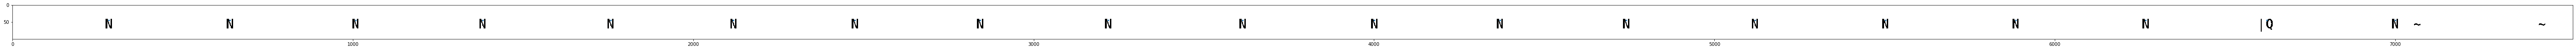

In [218]:
temp_img = cv2.imread('train/a2_15.png')
a=find_x(temp_img, 'blue', visualize=True)

In [219]:
def pixel_to_seconds(pixel_val):
    '''
    Convert pixel value into seconds for presenting output
    Assume every box is 0.2 sec
    '''
    
    #Start padding = 34 px, individual box width = 75px, box represents 0.2 sec
    act_time = ( (pixel_val - 34)/75 ) *0.2
    #find time at which identification happens
    time_range = np.arange(0.0, 20.0, 0.2)
    box_time = [x+0.2 for x in time_range if x <= act_time <= x+0.2]
    
    #return the second box in case point falls on line
    #check only 1 decimal place is included
    return float( "{:.1f}".format( max(box_time) ) )

In [220]:
#test on first image and manually verify
a = [113.0, 417.0, 719.0, 1013.0, 1308.0, 1602.0, 1907.0, 2150.0, 2520.0, 2835.0, 3137.0, 3431.0, 3719.0, 4032.0, 4351.0, 4657.0, 4966.0, 5272.0, 5568.0, 5865.0, 6160.0, 6467.0, 6791.0, 7097.0, 7390.0]
for i in a[:5]:
    print(pixel_to_seconds(i)) 

0.4
1.2
2.0
2.8
3.4


### Feature engineering

In [221]:
def get_graph_data(cropped_image):
    '''
    Find the y coordinates of all the black pixels detected in the window
    Input image shape: (750, 150, 3)
    '''
    
    #iterate over columnns instead of rows
    img = np.swapaxes(cropped_image,0,1)
    #shape is now (150,750,3)           
    
    y_pts = []    
    for col in img:
        #identify the indices of black pixels
        detection = [i for i,x in enumerate(col.tolist()) if x == [0,0,0]]
        #multiple detections or no detection, use previous val
        if len(detection)!= 1:
            if len(y_pts)>0: y_pts.append(y_pts[-1])
            #if no previous val exists, use central line of graph
            else: y_pts.append(750 - 440)
                
        else:
            #calculate value from bottom of image instead of top
            y_pts.append(750-detection[0])
            
    return y_pts              

In [222]:
len(get_graph_data(im[:, 34:34+150, :]))

150

In [223]:
def amplitude_data(y_pts, window_size = 50):
    '''
    Identify features pertaining to the amplitude
    
    Divide 150 length window into 3 windows for before, after and current trend of moving centres
    '''
    
    output = []
    for i in range(0, window_size*2+1, window_size):
        data = y_pts[i:i+window_size]
        output += [max(data), min(data), int(np.median(data))]
        
    return output

In [224]:
amplitude_data([1,1,2,2,3,3], window_size = 2)

[1, 1, 1, 2, 2, 2, 3, 3, 3]

In [225]:
def get_peak_data(main_pt, prev_pt = None, next_pt = None):
    '''
    Identify features relating to the observed peaks
    '''
    
    #if first peak
    if prev_pt == None:
        #subtract padding for first point 
        return [int(main_pt-34), int(next_pt-main_pt)]
    #if last peak
    if next_pt == None:
        #subtract padding from end
        return [int(main_pt-prev_pt), int((7522-34) - main_pt)]
    
    return [int(main_pt - prev_pt), int(next_pt-prev_pt)]
    

In [172]:
[]+[1]

[1]

In [226]:
def sliding_window(img, window_size=150):
    '''
    Run the sliding window to generate features and labels
    '''
    
    #get the X axis points for V beats
    vbeats_x = find_x(img, 'green')
    if math.isnan(vbeats_x[0]): vbeats_x = []
        
    labelling_dict = {k:1 for k in vbeats_x}
    
    #get the X axis points for other beats
    regular_beats = find_x(img, 'blue')
    
    for val in regular_beats: labelling_dict[val] = 0
        
    all_x = sorted(vbeats_x+regular_beats)
    
    features, labels = [], []

    #identify the features and label for each point
    for i,x in enumerate(all_x):
        #add the corresponding label
        labels.append(labelling_dict[x])
        
        #define window for 2 cells
        start, end = max([0,int(x-75)]), min([int(x+75), 7522])
        #get Y points in 150 length window
        y_pts = get_graph_data(img[:, start:end, :]) 
        
        #pad preceding or leading (750 - 440) for corner peaks
        if (x-75) < 0: 
            for _ in range(0-(int(x)-75)): y_pts.insert(0, 750-440)
        if (x+75) > 7522:
            for _ in range((int(x)+75)-7522): y_pts.append(750-440)
        
        #get peak features
        if i == 0: peak_feats = get_peak_data(x, next_pt=all_x[1])
        elif i == len(all_x)-1: peak_feats = get_peak_data(x, prev_pt=all_x[i-1])
        else: peak_feats = get_peak_data(x, prev_pt=all_x[i-1], next_pt=all_x[i+1])
        
        #combine y-axis coords, peak feats and amplitude feats
        features.append(y_pts + peak_feats + amplitude_data(y_pts))
        
    return features, labels

In [227]:
len(sliding_window(im)[0][0])

C:\anaconda\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\anaconda\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


161

### Generate training and testing data

In [228]:
#CREATE TRAINING DATA 
#call sliding window function for each image in train folder
features, labels = [],[]
for image in os.listdir('train'):
#     print (image)
    train_img = cv2.imread('train/'+ image)
    try:
        single_img_feats, single_img_labels = sliding_window(train_img)
    except:
        print (image)
    
    features+= single_img_feats
    labels+= single_img_labels

In [229]:
#distribution of labels
Counter(labels)

Counter({0: 13140, 1: 1095})

In [230]:
#SPLIT INTO TRAIN/TEST SETS
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=43, stratify=labels)

In [231]:
print (len(X_train), len(X_test))

11388 2847


In [232]:
#distribution of labels in train set
Counter(y_train)

Counter({0: 10512, 1: 876})

### Model Training 

In [ ]:
#define parameter grid to optimize GridSearch from
parameters = {'C':[0.0001,0.001,0.1,1.0], 'max_iter':[100,1000,10000]}

lr_model = LogisticRegression(random_state=43)

#uncomment to re-run GridSearch
# clf = GridSearchCV(lr_model, parameters).fit(X_train, y_train)

In [233]:
#evaluate optimal model on test set
preds_train = clf.predict(X_train)
preds_test = clf.predict(X_test)
print ("Train score: ", f1_score(y_train, preds_train), "\nTest score: ", f1_score(y_test, preds_test))

Train score:  0.9896670493685419 
Test score:  0.9792147806004619


In [ ]:
#get the optimal params from GridSearch object
clf.get_params()

In [234]:
#fit a new optimal from optimal params
new_lr_model = LogisticRegression(C=0.0001,max_iter=1000,random_state=43).fit(X_train, y_train)


### Model evaluation

In [235]:
#evaluate optimal model on test set
preds_train = new_lr_model.predict(X_train)
preds_test = new_lr_model.predict(X_test)
print ("Train score: ", f1_score(y_train, preds_train), "\nTest score: ", f1_score(y_test, preds_test))

Train score:  0.9891117478510029 
Test score:  0.9769585253456221


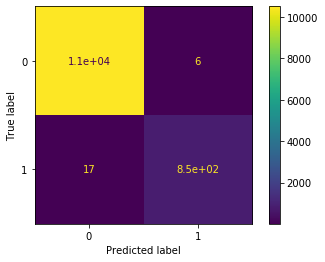

In [192]:
#PLOT the confusion matrix
plot_confusion_matrix(new_lr_model, X_train, y_train)
plt.show() 

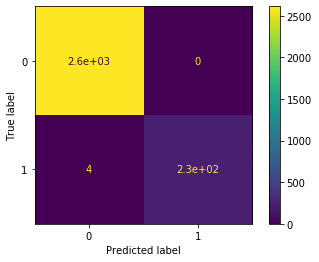

In [193]:
plot_confusion_matrix(new_lr_model, X_test, y_test)
plt.show() 

In [194]:
#get probabilities of predictions
probs = new_lr_model.predict_proba(X_test)

#check quality of predictions for positive class
prob_1 = probs[np.where(preds_test==1)]
pd.DataFrame(prob_1).describe()

,0,1
count,228.000000,228.000000
mean,0.011643,0.988357
std,0.046372,0.046372
min,0.000000,0.507594
25%,0.000002,0.999059
50%,0.000051,0.999949
75%,0.000941,0.999998
max,0.492406,1.000000


In [195]:
#check quality of predictions for neagative class

prob_0 = probs[np.where(preds_test==0)]
pd.DataFrame(prob_0).describe()

,0,1
count,2619.000000,2.619000e+03
mean,0.997866,2.134285e-03
std,0.015839,1.583889e-02
min,0.595471,2.160497e-08
25%,0.998757,2.052306e-04
50%,0.999447,5.533393e-04
75%,0.999795,1.243082e-03
max,1.000000,4.045293e-01


The mean prediction probability is ~0.99 for both classes which indicate the model is performing well. 

In [ ]:
# get importance
importance = new_lr_model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

In [236]:
#Pick the most important features
for i,v in enumerate(importance):
    if v > 0.01 or v < -0.01:
        print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 65, Score: 0.01430
Feature: 66, Score: 0.01429
Feature: 67, Score: 0.01392
Feature: 68, Score: 0.01014
Feature: 85, Score: 0.01757
Feature: 86, Score: 0.01161
Feature: 149, Score: 0.01118
Feature: 150, Score: -0.01666
Feature: 153, Score: -0.01168
Feature: 155, Score: 0.01717
Feature: 156, Score: -0.02377
Feature: 158, Score: 0.01701
Feature: 159, Score: -0.02439


It seems that the peak information wasn't as critical. median of preceding frame from peak (feature 155), min and median of peak (156 and 158) and min of next frame from peak (159) were some of the critical features in the additional data added. 

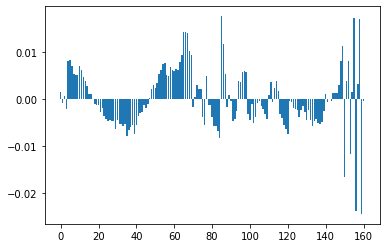

In [237]:
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

Seemingly even spread of feature importance. 

In [ ]:
from joblib import dump
dump(new_lr_model, 'LR_model_v1_03112020.joblib') 

### Prediction 

In [199]:
test_img = cv2.imread('test/b1_0.png')
single_img_feats,_ = sliding_window(test_img)
len(single_img_feats)

C:\anaconda\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\anaconda\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


28

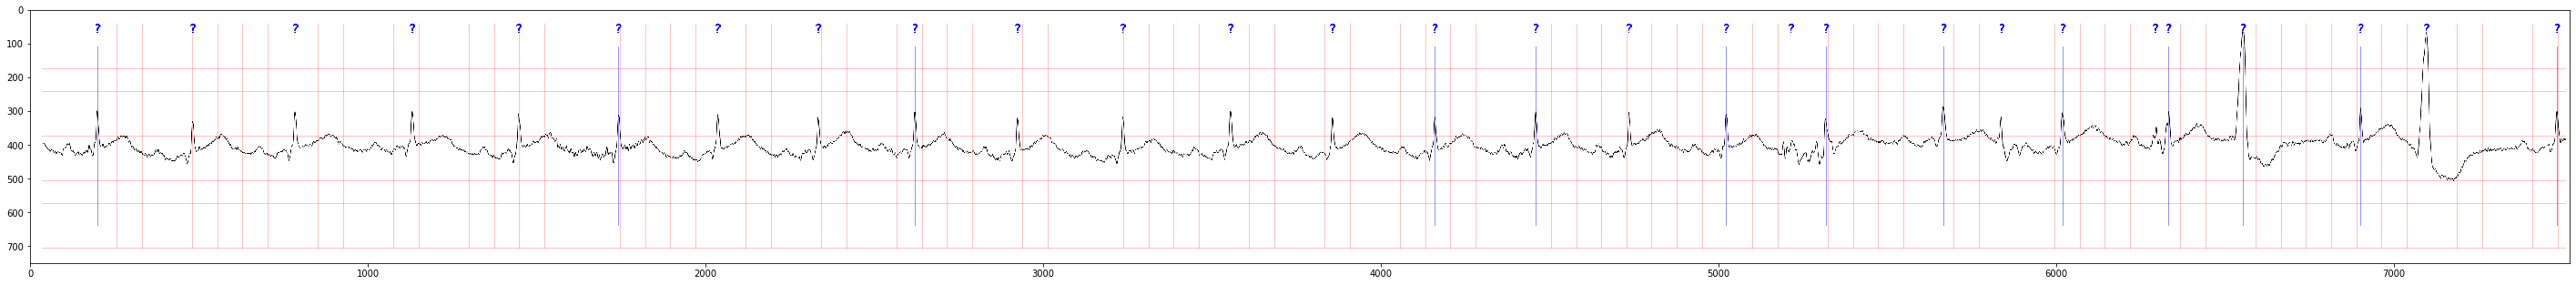

In [200]:
plt.figure(figsize=(50,100))
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
plt.show()

In [201]:
test_pred = new_lr_model.predict(single_img_feats)
test_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0])

Visually, the prediction appears to be correct. Second and fourth from last are the V beats

In [202]:
np.where(test_pred == 1)[0]

array([24, 26], dtype=int64)

In [203]:
#for all positive detections, find corresponding X coordinate
for i in np.where(test_pred == 1)[0]:
    # find x coordinate of the detected point
    x_coord = find_x(test_img, 'blue')[i]
    #find the time corresponding to the pixel value
    time = pixel_to_seconds(x_coord)
    print (time)

17.4
19.0


In [238]:
##TEST individual images
test_img = cv2.imread('test/b1_1.png')
single_img_feats,_ = sliding_window(test_img)
new_lr_model.predict(single_img_feats)

C:\anaconda\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\anaconda\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


array([1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0])

### Generate predictions in CSV file

In [ ]:
#GENERATE features for test data
outputs = []
for image in os.listdir('test'):
    test_img = cv2.imread('test/' + image)
    
    #find features for the individual image
    single_img_feats,_ = sliding_window(test_img)
    #get test predictions
    test_pred = new_lr_model.predict(single_img_feats)

    #for all positive detections, find corresponding X coordinate
    for i in np.where(test_pred == 1)[0]:
        # find x coordinate of the detected point
        x_coord = find_x(test_img, 'blue')[i]
        #find the time corresponding to the pixel value
        time = pixel_to_seconds(x_coord)
        
        outputs.append([image, time])

In [ ]:
#Save to CSV file
pd.DataFrame(outputs).to_csv('output.csv',index=False)

In [ ]:
outputs

In [240]:
tmp = [x[0] for x in outputs]
len(set(tmp))

176

In [241]:
#Find images without positive class prediction
set(os.listdir('test'))-set(tmp)

{'b1_46.png', 'b1_54.png', 'b1_58.png', 'b1_59.png'}

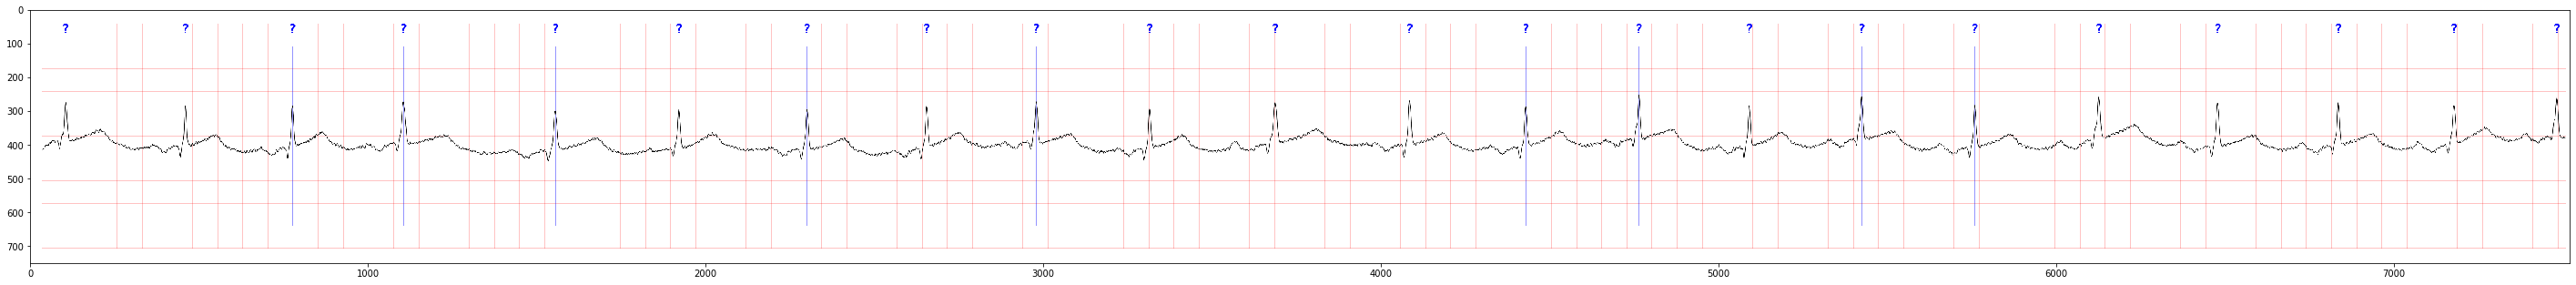

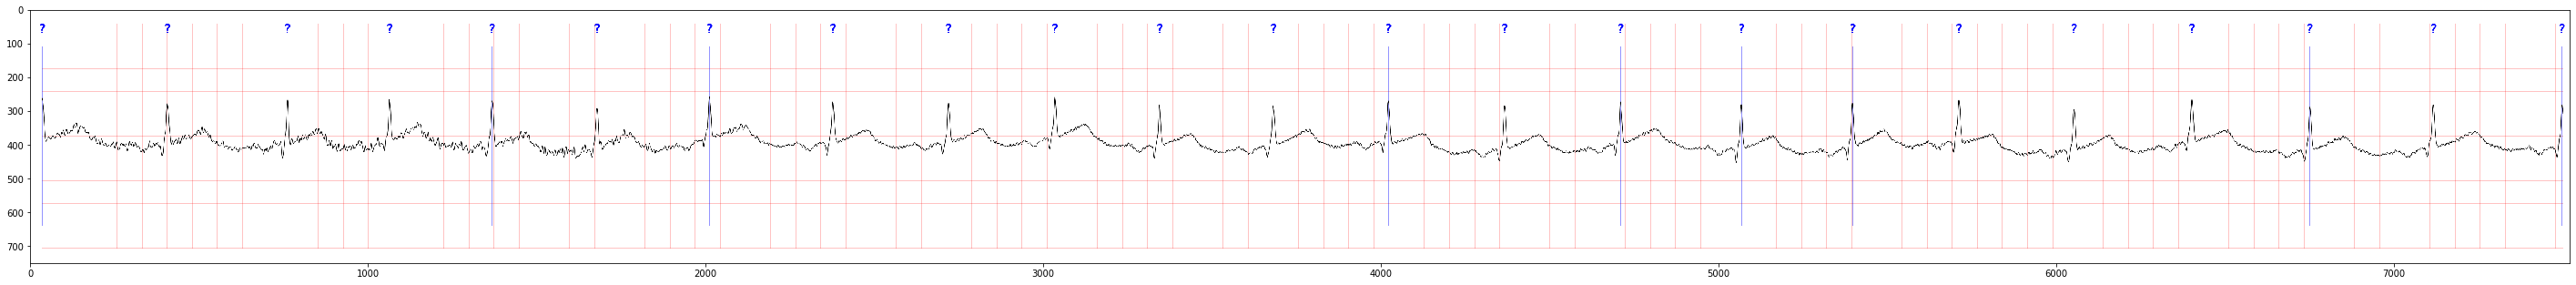

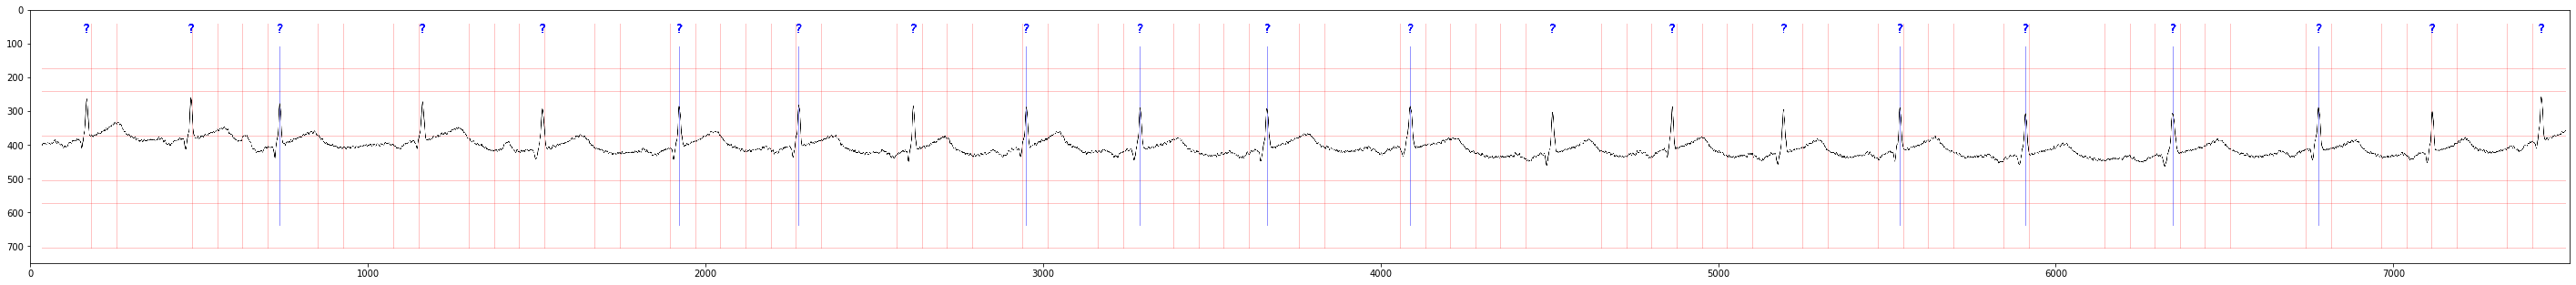

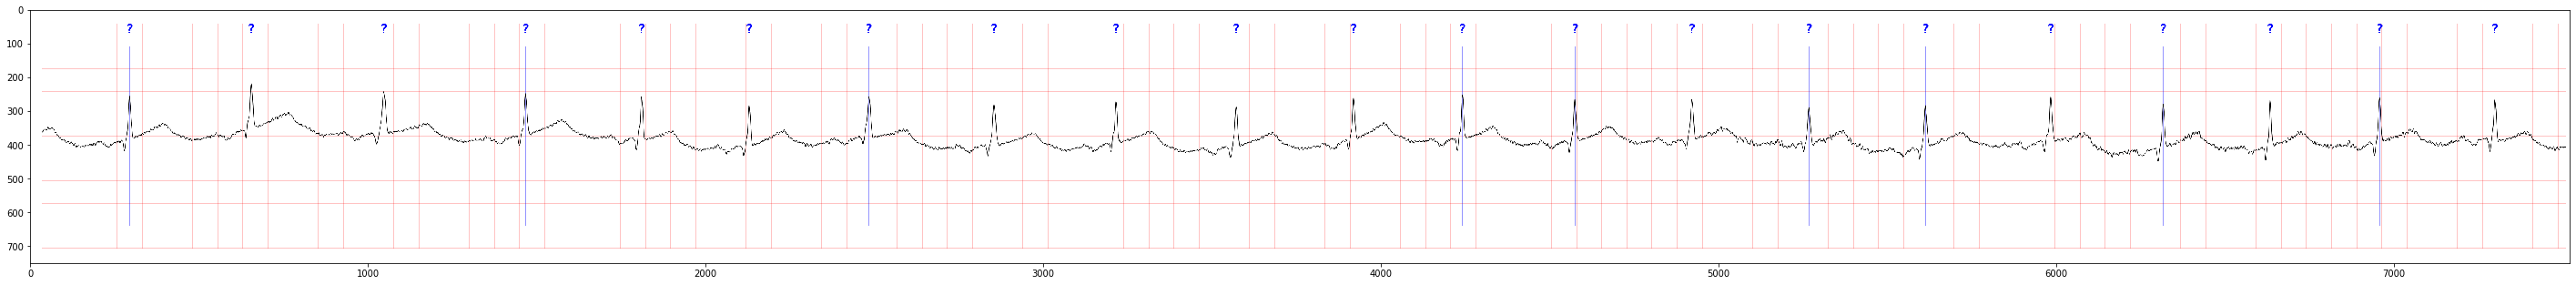

In [242]:
#visualize the images where no V beat was predicted
for i in ['b1_46.png', 'b1_54.png', 'b1_58.png', 'b1_59.png']:
    tmp_img = cv2.imread('test/'+i)
    plt.figure(figsize=(50,100))
    plt.imshow(cv2.cvtColor(tmp_img, cv2.COLOR_BGR2RGB))
    plt.show()

There are no V beats in these 4 images. 